Medicine Classification


In [4]:
import os
import json
from datetime import datetime
from typing import Tuple, Dict

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import timm
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


ModuleNotFoundError: No module named 'torch'

In [ ]:
def get_dataloaders(
    data_root: str,
    img_size: int = 224,
    batch_size: int = 32,
    num_workers: int = 4,
) -> Tuple[DataLoader, DataLoader, DataLoader, int, Dict[int, str]]:

    train_dir = os.path.join(data_root, "train")
    val_dir = os.path.join(data_root, "val")
    test_dir = os.path.join(data_root, "test")

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    train_transform = transforms.Compose([
        transforms.Resize((img_size + 32, img_size + 32)),
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    eval_transform = transforms.Compose([
        transforms.Resize((img_size + 32, img_size + 32)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    val_dataset = datasets.ImageFolder(val_dir, transform=eval_transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=eval_transform)

    num_classes = len(train_dataset.classes)
    idx_to_class = {i: c for i, c in enumerate(train_dataset.classes)}

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )

    return train_loader, val_loader, test_loader, num_classes, idx_to_class

def build_resnet(num_classes: int, variant: str = "resnet18", pretrained: bool = True) -> nn.Module:
    if variant == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        in_features = model.fc.in_features
    elif variant == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None)
        in_features = model.fc.in_features
    else:
        raise ValueError(f"Unsupported ResNet variant: {variant}")

    model.fc = nn.Linear(in_features, num_classes)
    return model

def build_vit(num_classes: int, variant: str = "vit_b16", pretrained: bool = True) -> nn.Module:
    if variant == "vit_b16":
        name = "vit_base_patch16_224"
    elif variant == "vit_s16":
        name = "vit_small_patch16_224"
    else:
        raise ValueError(f"Unsupported ViT variant: {variant}")

    model = timm.create_model(name, pretrained=pretrained, num_classes=num_classes)
    return model

def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    device: torch.device,
) -> Tuple[float, float]:
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

def eval_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> Tuple[float, float]:
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

def test_model(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
) -> Tuple[float, np.ndarray, np.ndarray]:
    model.eval()
    correct = 0
    total = 0
    all_true = []
    all_pred = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

            all_true.extend(labels.cpu().numpy())
            all_pred.extend(preds.cpu().numpy())

    acc = correct / total
    return acc, np.array(all_true), np.array(all_pred)


In [ ]:
config = {
    "data_root": "medicine_boxes_split",
    "models": ["resnet18", "resnet50", "vit_b16", "vit_s16"],
    "epochs": 15,
    "batch_size": 32,
    "img_size": 224,
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "num_workers": 4,
    "pretrained": True,
    "results_dir": "results",
}
os.makedirs(config["results_dir"], exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_base = os.path.join(config["results_dir"], f"run_{timestamp}")
os.makedirs(results_base, exist_ok=True)

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")
print(f"\nResults will be saved to: {results_base}")


Configuration:
  data_root: medicine_boxes_split
  models: ['resnet18', 'resnet50', 'vit_b16', 'vit_s16']
  epochs: 15
  batch_size: 32
  img_size: 224
  lr: 0.0001
  weight_decay: 0.0001
  num_workers: 4
  pretrained: True
  results_dir: results

Results will be saved to: results/run_20251212_150056


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_loader, val_loader, test_loader, num_classes, idx_to_class = get_dataloaders(
    data_root=config["data_root"],
    img_size=config["img_size"],
    batch_size=config["batch_size"],
    num_workers=config["num_workers"],
)

print(f"\nFound {num_classes} classes:")
for idx, name in idx_to_class.items():
    print(f"  {idx}: {name}")
class_mapping_path = os.path.join(results_base, "class_mapping.json")
with open(class_mapping_path, "w") as f:
    json.dump({str(k): v for k, v in idx_to_class.items()}, f, indent=2)
print(f"\nClass mapping saved to: {class_mapping_path}")


Using device: cpu

Found 20 classes:
  0: acetaminophen
  1: albuterol
  2: amlodipine
  3: amoxicillin
  4: aspirin
  5: atorvastatin
  6: azithromycin
  7: cetirizine
  8: clopidogrel
  9: furosemide
  10: ibuprofen
  11: levothyroxine
  12: lisinopril
  13: loratadine
  14: losartan
  15: metformin
  16: naproxen
  17: omeprazole
  18: pantoprazole
  19: simvastatin

Class mapping saved to: results/run_20251212_150056/class_mapping.json


In [ ]:
all_results = {}

for model_name in config["models"]:
    print("\n" + "="*80)
    print(f"Training Model: {model_name}")
    print("="*80)
    
    model_dir = os.path.join(results_base, model_name)
    os.makedirs(model_dir, exist_ok=True)
    
    if model_name.startswith("resnet"):
        model = build_resnet(num_classes, variant=model_name, pretrained=config["pretrained"])
    else:
        model = build_vit(num_classes, variant=model_name, pretrained=config["pretrained"])
    
    model = model.to(device)
    num_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {num_params:,}")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
    try:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", factor=0.5, patience=3, verbose=False
        )
    except TypeError:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", factor=0.5, patience=3
        )
    
    best_val_acc = 0.0
    best_state = None
    train_history = {"loss": [], "acc": []}
    val_history = {"loss": [], "acc": []}
    
    print("\nStarting training...\n")
    
    for epoch in range(1, config["epochs"] + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = eval_epoch(model, val_loader, criterion, device)
        
        scheduler.step(val_acc)
        
        train_history["loss"].append(train_loss)
        train_history["acc"].append(train_acc)
        val_history["loss"].append(val_loss)
        val_history["acc"].append(val_acc)
        
        print(
            f"Epoch {epoch:02d}/{config['epochs']:02d} | "
            f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
            f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}"
        )
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()
    
    print(f"\nBest val acc: {best_val_acc:.4f}")
    if best_state is not None:
        model.load_state_dict(best_state)
    
    checkpoint_path = os.path.join(model_dir, "best_model.pth")
    torch.save({
        "model_state_dict": model.state_dict(),
        "model_name": model_name,
        "num_classes": num_classes,
        "best_val_acc": best_val_acc,
        "config": config,
    }, checkpoint_path)
    print(f"Model saved to: {checkpoint_path}")
    
    test_acc, y_true, y_pred = test_model(model, test_loader, device)
    print(f"\nTest accuracy: {test_acc:.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    target_names = [idx_to_class[i] for i in sorted(idx_to_class.keys())]
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    
    print("\nConfusion Matrix (rows=true, cols=predicted):")
    print(cm)
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))
    metrics = {
        "model_name": model_name,
        "num_parameters": num_params,
        "best_val_acc": float(best_val_acc),
        "test_acc": float(test_acc),
        "train_history": {k: [float(x) for x in v] for k, v in train_history.items()},
        "val_history": {k: [float(x) for x in v] for k, v in val_history.items()},
        "classification_report": report,
    }
    
    metrics_path = os.path.join(model_dir, "metrics.json")
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=2)
    print(f"Metrics saved to: {metrics_path}")
    
    cm_path = os.path.join(model_dir, "confusion_matrix.npy")
    np.save(cm_path, cm)
    print(f"Confusion matrix saved to: {cm_path}")
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].plot(train_history["loss"], label="Train Loss", marker="o")
    axes[0].plot(val_history["loss"], label="Val Loss", marker="s")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title(f"{model_name} - Training and Validation Loss")
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(train_history["acc"], label="Train Acc", marker="o")
    axes[1].plot(val_history["acc"], label="Val Acc", marker="s")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title(f"{model_name} - Training and Validation Accuracy")
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    history_plot_path = os.path.join(model_dir, "training_history.png")
    plt.savefig(history_plot_path, dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Training history plot saved to: {history_plot_path}")
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=target_names, yticklabels=target_names,
                cbar_kws={"label": "Count"})
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    cm_plot_path = os.path.join(model_dir, "confusion_matrix.png")
    plt.savefig(cm_plot_path, dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Confusion matrix plot saved to: {cm_plot_path}")
    
    class_names = [idx_to_class[i] for i in sorted(idx_to_class.keys())]
    precisions = [report[name]["precision"] for name in class_names]
    recalls = [report[name]["recall"] for name in class_names]
    f1_scores = [report[name]["f1-score"] for name in class_names]
    
    x = np.arange(len(class_names))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(x - width, precisions, width, label="Precision", alpha=0.8)
    ax.bar(x, recalls, width, label="Recall", alpha=0.8)
    ax.bar(x + width, f1_scores, width, label="F1-Score", alpha=0.8)
    
    ax.set_xlabel("Class")
    ax.set_ylabel("Score")
    ax.set_title(f"{model_name} - Per-Class Metrics")
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.legend()
    ax.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    metrics_plot_path = os.path.join(model_dir, "per_class_metrics.png")
    plt.savefig(metrics_plot_path, dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Per-class metrics plot saved to: {metrics_plot_path}")
    
    all_results[model_name] = {
        "test_acc": float(test_acc),
        "best_val_acc": float(best_val_acc),
        "num_parameters": num_params,
    }
    
    print(f"\nCompleted training for {model_name}")
    print(f"All outputs saved to: {model_dir}\n")



Training Model: resnet18
Total parameters: 11,186,772

Starting training...

Epoch 01/15 | Train loss: 2.3272, acc: 0.3348 | Val loss: 1.7657, acc: 0.4515
Epoch 02/15 | Train loss: 1.4762, acc: 0.5935 | Val loss: 1.4688, acc: 0.5579
Epoch 03/15 | Train loss: 1.1046, acc: 0.7047 | Val loss: 1.3557, acc: 0.5934
Epoch 04/15 | Train loss: 0.8624, acc: 0.7735 | Val loss: 1.1896, acc: 0.6572
Epoch 05/15 | Train loss: 0.7053, acc: 0.8046 | Val loss: 1.1660, acc: 0.6690
Epoch 06/15 | Train loss: 0.5700, acc: 0.8600 | Val loss: 1.0968, acc: 0.6903
Epoch 07/15 | Train loss: 0.4885, acc: 0.8714 | Val loss: 1.0706, acc: 0.6903
Epoch 08/15 | Train loss: 0.4206, acc: 0.8828 | Val loss: 0.9695, acc: 0.7234
Epoch 09/15 | Train loss: 0.3486, acc: 0.9026 | Val loss: 0.9849, acc: 0.7376
Epoch 10/15 | Train loss: 0.3157, acc: 0.9125 | Val loss: 0.9771, acc: 0.7329
Epoch 11/15 | Train loss: 0.2945, acc: 0.9115 | Val loss: 0.9529, acc: 0.7518
Epoch 12/15 | Train loss: 0.2828, acc: 0.9238 | Val loss: 0.9015

100%|██████████| 97.8M/97.8M [00:04<00:00, 22.0MB/s]


Total parameters: 23,549,012

Starting training...



/Users/aditya/Desktop/UIUC/CS441/Project/AML_Proj/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01/15 | Train loss: 2.3279, acc: 0.3403 | Val loss: 1.8159, acc: 0.4374
Epoch 02/15 | Train loss: 1.4443, acc: 0.5930 | Val loss: 1.4668, acc: 0.5816
Epoch 03/15 | Train loss: 1.0730, acc: 0.6860 | Val loss: 1.2378, acc: 0.6383
Epoch 04/15 | Train loss: 0.8419, acc: 0.7572 | Val loss: 1.0624, acc: 0.6761
Epoch 05/15 | Train loss: 0.7202, acc: 0.7923 | Val loss: 1.0818, acc: 0.6950
Epoch 06/15 | Train loss: 0.5763, acc: 0.8254 | Val loss: 1.1067, acc: 0.6690
Epoch 07/15 | Train loss: 0.4639, acc: 0.8714 | Val loss: 0.9734, acc: 0.7187
Epoch 08/15 | Train loss: 0.3808, acc: 0.8808 | Val loss: 0.8689, acc: 0.7210
Epoch 09/15 | Train loss: 0.3522, acc: 0.8971 | Val loss: 0.9004, acc: 0.7423
Epoch 10/15 | Train loss: 0.3481, acc: 0.8947 | Val loss: 1.1417, acc: 0.6974
Epoch 11/15 | Train loss: 0.2840, acc: 0.9100 | Val loss: 0.9682, acc: 0.7305
Epoch 12/15 | Train loss: 0.2439, acc: 0.9209 | Val loss: 1.0412, acc: 0.7470
Epoch 13/15 | Train loss: 0.2560, acc: 0.9159 | Val loss: 0.9865

/Users/aditya/Desktop/UIUC/CS441/Project/AML_Proj/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01/15 | Train loss: 2.9707, acc: 0.0861 | Val loss: 2.6717, acc: 0.1915
Epoch 02/15 | Train loss: 2.3744, acc: 0.2725 | Val loss: 2.3400, acc: 0.3144
Epoch 03/15 | Train loss: 1.8131, acc: 0.4496 | Val loss: 1.7889, acc: 0.4704
Epoch 04/15 | Train loss: 1.3769, acc: 0.5865 | Val loss: 1.8707, acc: 0.4775
Epoch 05/15 | Train loss: 1.0976, acc: 0.6508 | Val loss: 1.5712, acc: 0.5154
Epoch 06/15 | Train loss: 0.9857, acc: 0.6914 | Val loss: 1.4985, acc: 0.5437
Epoch 07/15 | Train loss: 0.8015, acc: 0.7404 | Val loss: 1.3617, acc: 0.6099
Epoch 08/15 | Train loss: 0.7378, acc: 0.7498 | Val loss: 1.3556, acc: 0.6265
Epoch 09/15 | Train loss: 0.6797, acc: 0.7779 | Val loss: 1.2635, acc: 0.6265
Epoch 10/15 | Train loss: 0.6290, acc: 0.7918 | Val loss: 1.3891, acc: 0.6312
Epoch 11/15 | Train loss: 0.5576, acc: 0.8056 | Val loss: 1.4607, acc: 0.5887
Epoch 12/15 | Train loss: 0.5826, acc: 0.8046 | Val loss: 1.3047, acc: 0.6572
Epoch 13/15 | Train loss: 0.5325, acc: 0.8195 | Val loss: 1.2920

/Users/aditya/Desktop/UIUC/CS441/Project/AML_Proj/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01/15 | Train loss: 2.8731, acc: 0.1335 | Val loss: 2.5331, acc: 0.2317
Epoch 02/15 | Train loss: 2.2028, acc: 0.3427 | Val loss: 1.9980, acc: 0.4326
Epoch 03/15 | Train loss: 1.5853, acc: 0.5326 | Val loss: 1.9669, acc: 0.4019
Epoch 04/15 | Train loss: 1.3616, acc: 0.6058 | Val loss: 1.5797, acc: 0.5296
Epoch 05/15 | Train loss: 1.0418, acc: 0.6869 | Val loss: 1.4959, acc: 0.5532
Epoch 06/15 | Train loss: 0.8534, acc: 0.7404 | Val loss: 1.2746, acc: 0.6241
Epoch 07/15 | Train loss: 0.6944, acc: 0.7794 | Val loss: 1.2751, acc: 0.6265
Epoch 08/15 | Train loss: 0.6409, acc: 0.7977 | Val loss: 1.2379, acc: 0.6194
Epoch 09/15 | Train loss: 0.5856, acc: 0.8229 | Val loss: 1.2623, acc: 0.6076
Epoch 10/15 | Train loss: 0.5216, acc: 0.8338 | Val loss: 1.2200, acc: 0.6241
Epoch 11/15 | Train loss: 0.5222, acc: 0.8338 | Val loss: 1.1365, acc: 0.6714
Epoch 12/15 | Train loss: 0.4423, acc: 0.8526 | Val loss: 1.1197, acc: 0.6596
Epoch 13/15 | Train loss: 0.4176, acc: 0.8561 | Val loss: 1.1853

In [ ]:
print("\n" + "="*80)
print("SUMMARY OF ALL MODELS")
print("="*80)
print(f"{'Model':<15} {'Test Acc':<12} {'Val Acc':<12} {'Parameters':<15}")
print("-"*80)

for model_name, results in all_results.items():
    print(f"{model_name:<15} {results['test_acc']:<12.4f} {results['best_val_acc']:<12.4f} {results['num_parameters']:<15,}")

summary_path = os.path.join(results_base, "summary.json")
with open(summary_path, "w") as f:
    json.dump(all_results, f, indent=2)
print(f"\nSummary saved to: {summary_path}")

best_model = max(all_results.items(), key=lambda x: x[1]["test_acc"])
print(f"\nBest Model: {best_model[0]} (Test Acc: {best_model[1]['test_acc']:.4f})")
print(f"\nAll results saved to: {results_base}")



SUMMARY OF ALL MODELS
Model           Test Acc     Val Acc      Parameters     
--------------------------------------------------------------------------------
resnet18        0.7534       0.7660       11,186,772     
resnet50        0.7713       0.7683       23,549,012     
vit_b16         0.6413       0.6572       85,814,036     
vit_s16         0.6906       0.6785       21,673,364     

Summary saved to: results/run_20251212_150056/summary.json

Best Model: resnet50 (Test Acc: 0.7713)

All results saved to: results/run_20251212_150056


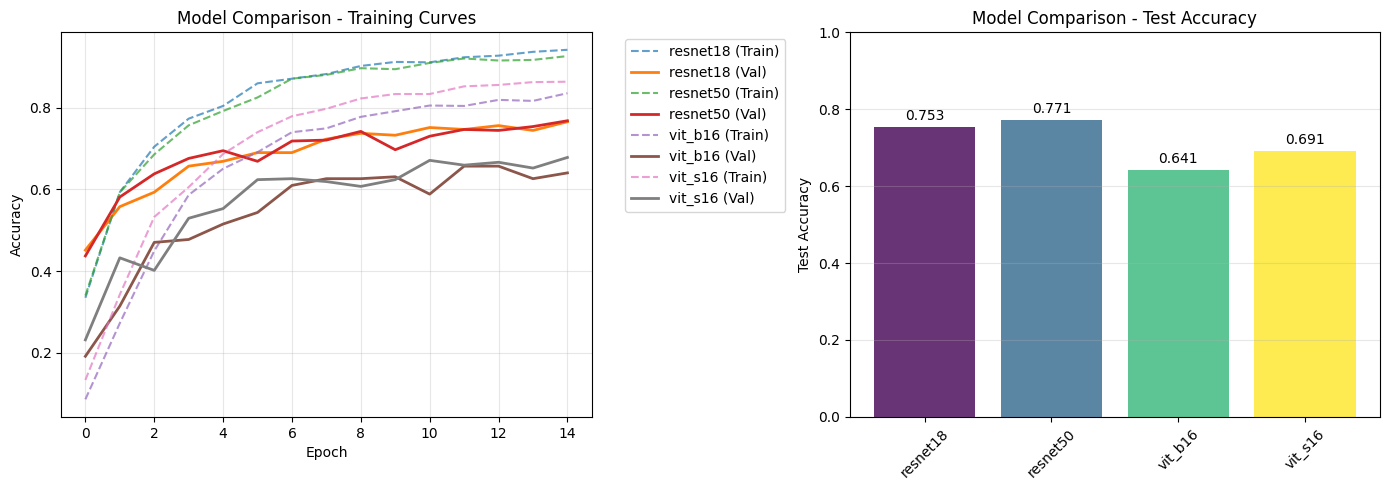

Comparison plot saved to: results/run_20251212_150056/comparison/model_comparison.png


In [ ]:
comparison_dir = os.path.join(results_base, "comparison")
os.makedirs(comparison_dir, exist_ok=True)

all_train_histories = {}
all_val_histories = {}
all_test_accs = {}

for model_name in config["models"]:
    metrics_path = os.path.join(results_base, model_name, "metrics.json")
    if os.path.exists(metrics_path):
        with open(metrics_path, "r") as f:
            metrics = json.load(f)
            all_train_histories[model_name] = metrics["train_history"]["acc"]
            all_val_histories[model_name] = metrics["val_history"]["acc"]
            all_test_accs[model_name] = metrics["test_acc"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for model_name in all_train_histories.keys():
    axes[0].plot(all_train_histories[model_name], label=f"{model_name} (Train)", linestyle="--", alpha=0.7)
    axes[0].plot(all_val_histories[model_name], label=f"{model_name} (Val)", linewidth=2)

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Model Comparison - Training Curves")
axes[0].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
axes[0].grid(True, alpha=0.3)

models = list(all_test_accs.keys())
accs = list(all_test_accs.values())
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

axes[1].bar(models, accs, color=colors, alpha=0.8)
axes[1].set_ylabel("Test Accuracy")
axes[1].set_title("Model Comparison - Test Accuracy")
axes[1].set_ylim([0, 1])
axes[1].grid(True, axis="y", alpha=0.3)
axes[1].tick_params(axis="x", rotation=45)

for i, (model, acc) in enumerate(zip(models, accs)):
    axes[1].text(i, acc + 0.01, f"{acc:.3f}", ha="center", va="bottom")

plt.tight_layout()
comparison_plot_path = os.path.join(comparison_dir, "model_comparison.png")
plt.savefig(comparison_plot_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"Comparison plot saved to: {comparison_plot_path}")


In [ ]:
print(f"Results directory: {results_base}")
print("\nDirectory structure:")
for root, dirs, files in os.walk(results_base):
    level = root.replace(results_base, "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 2 * (level + 1)
    for file in files[:10]:
        print(f"{subindent}{file}")
    if len(files) > 10:
        print(f"{subindent}... and {len(files) - 10} more files")


Results directory: results/run_20251212_150056

Directory structure:
run_20251212_150056/
  summary.json
  class_mapping.json
  vit_s16/
    confusion_matrix.png
    metrics.json
    per_class_metrics.png
    training_history.png
    confusion_matrix.npy
    best_model.pth
  resnet50/
    confusion_matrix.png
    metrics.json
    per_class_metrics.png
    training_history.png
    confusion_matrix.npy
    best_model.pth
  vit_b16/
    confusion_matrix.png
    metrics.json
    per_class_metrics.png
    training_history.png
    confusion_matrix.npy
    best_model.pth
  resnet18/
    confusion_matrix.png
    metrics.json
    per_class_metrics.png
    training_history.png
    confusion_matrix.npy
    best_model.pth
  comparison/
    model_comparison.png


In [ ]:
if os.path.exists(summary_path):
    with open(summary_path, "r") as f:
        summary = json.load(f)
    
    print("\nSummary of Results:")
    print(json.dumps(summary, indent=2))



Summary of Results:
{
  "resnet18": {
    "test_acc": 0.7533632286995515,
    "best_val_acc": 0.7659574468085106,
    "num_parameters": 11186772
  },
  "resnet50": {
    "test_acc": 0.7713004484304933,
    "best_val_acc": 0.7683215130023641,
    "num_parameters": 23549012
  },
  "vit_b16": {
    "test_acc": 0.6412556053811659,
    "best_val_acc": 0.6572104018912529,
    "num_parameters": 85814036
  },
  "vit_s16": {
    "test_acc": 0.6905829596412556,
    "best_val_acc": 0.6784869976359338,
    "num_parameters": 21673364
  }
}



Images for RESNET18

confusion_matrix.png:


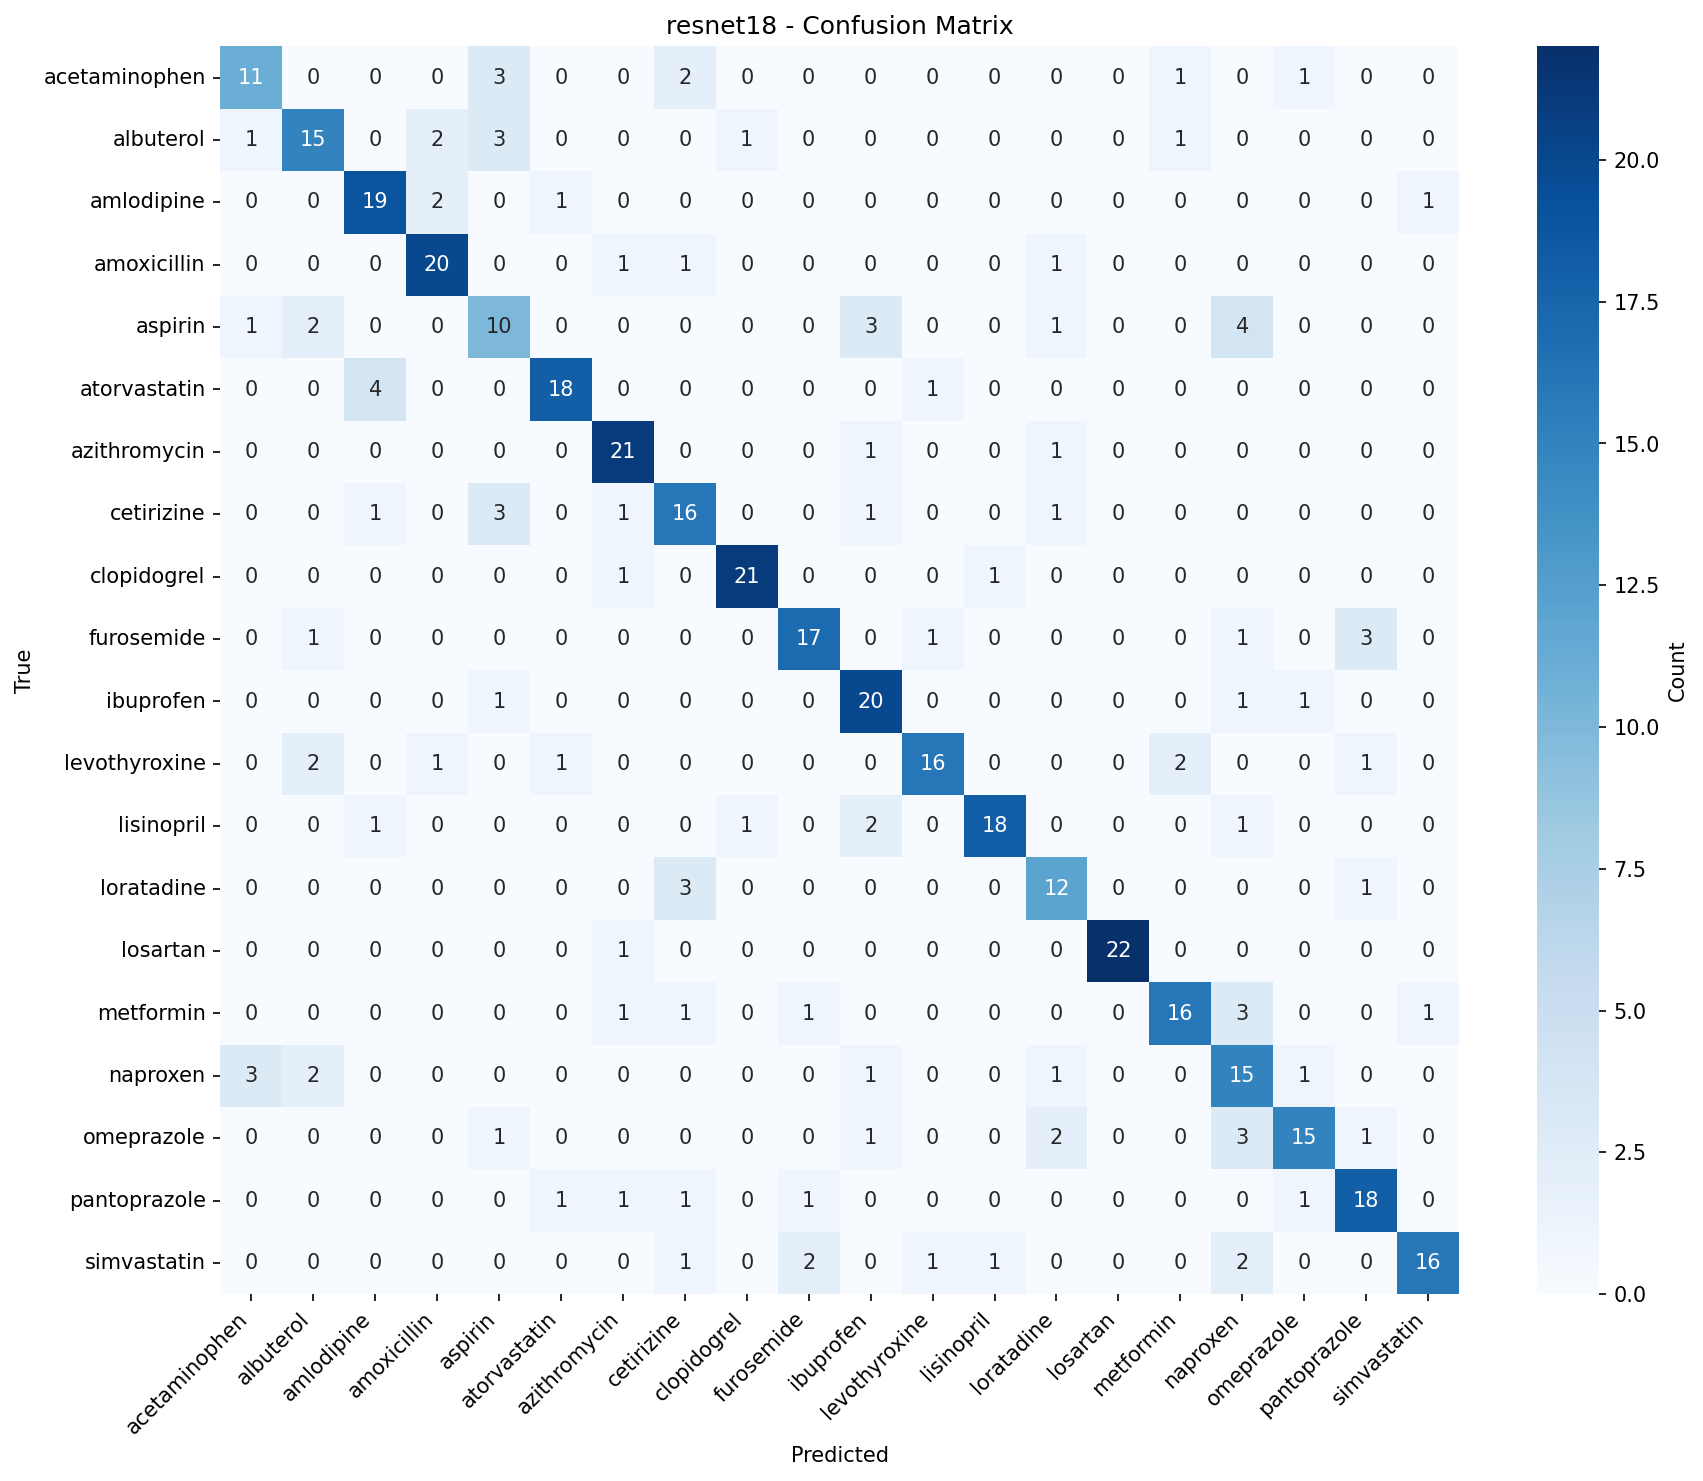


per_class_metrics.png:


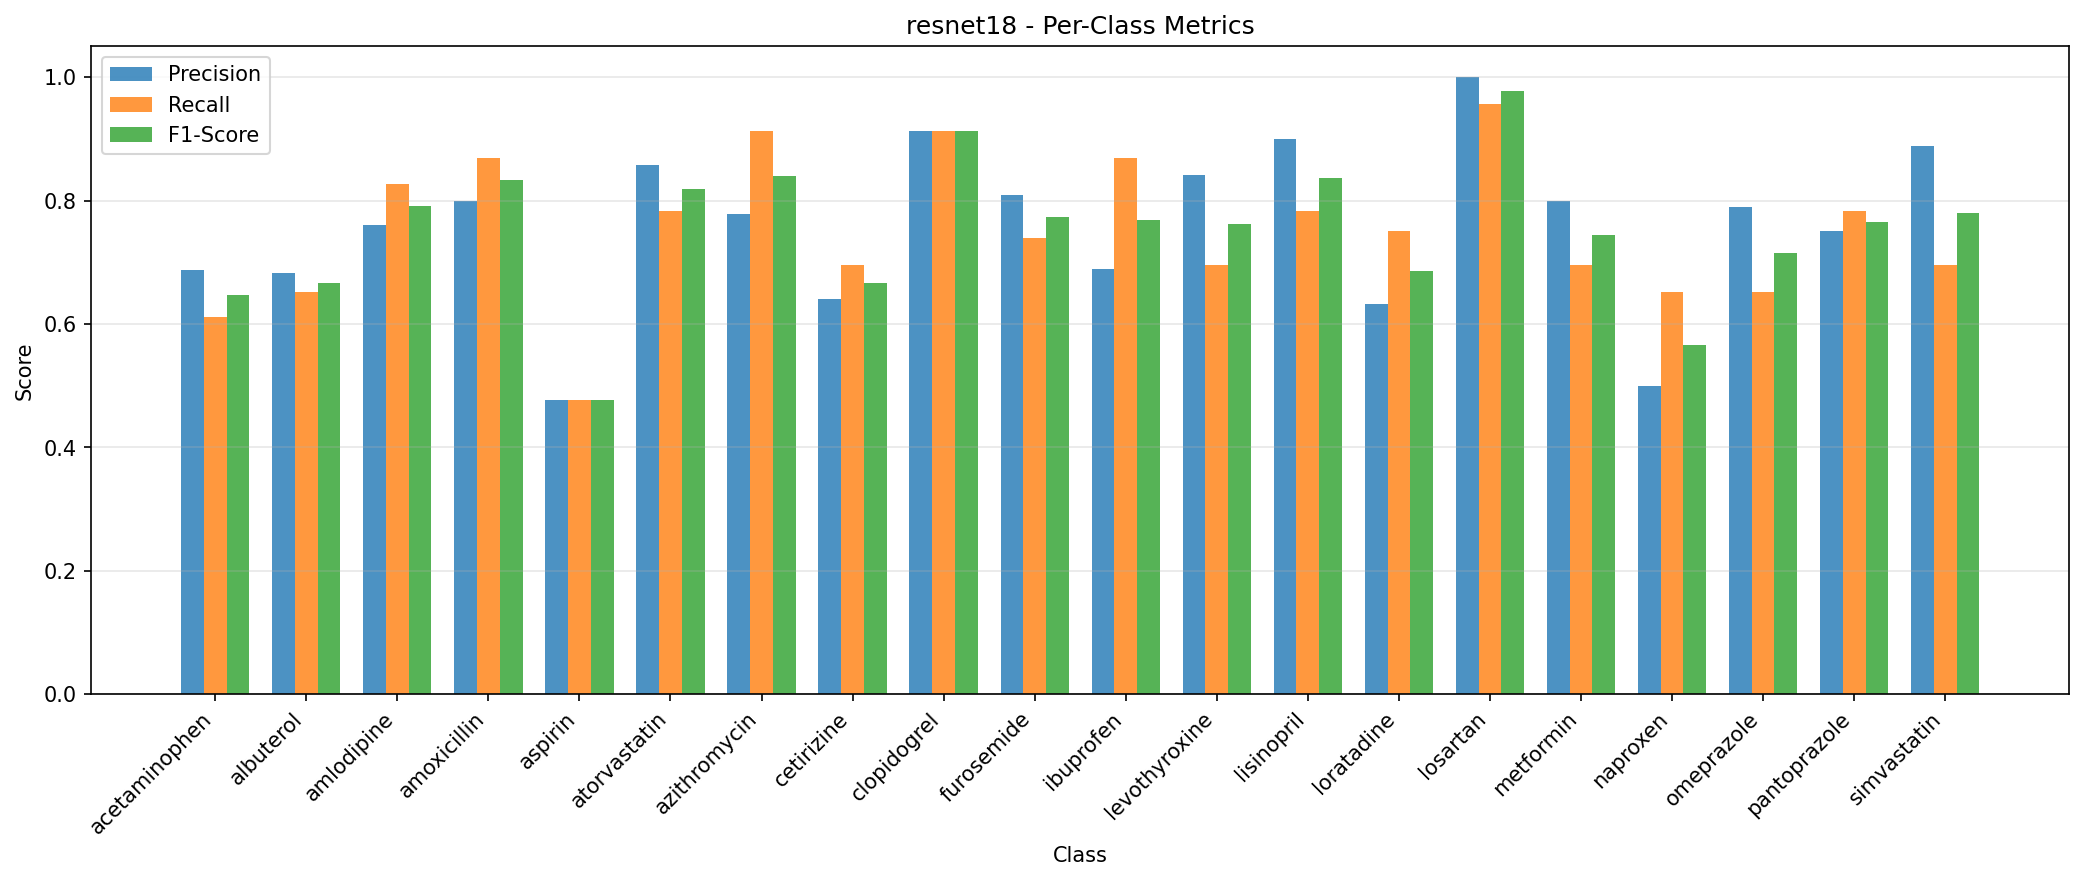


training_history.png:


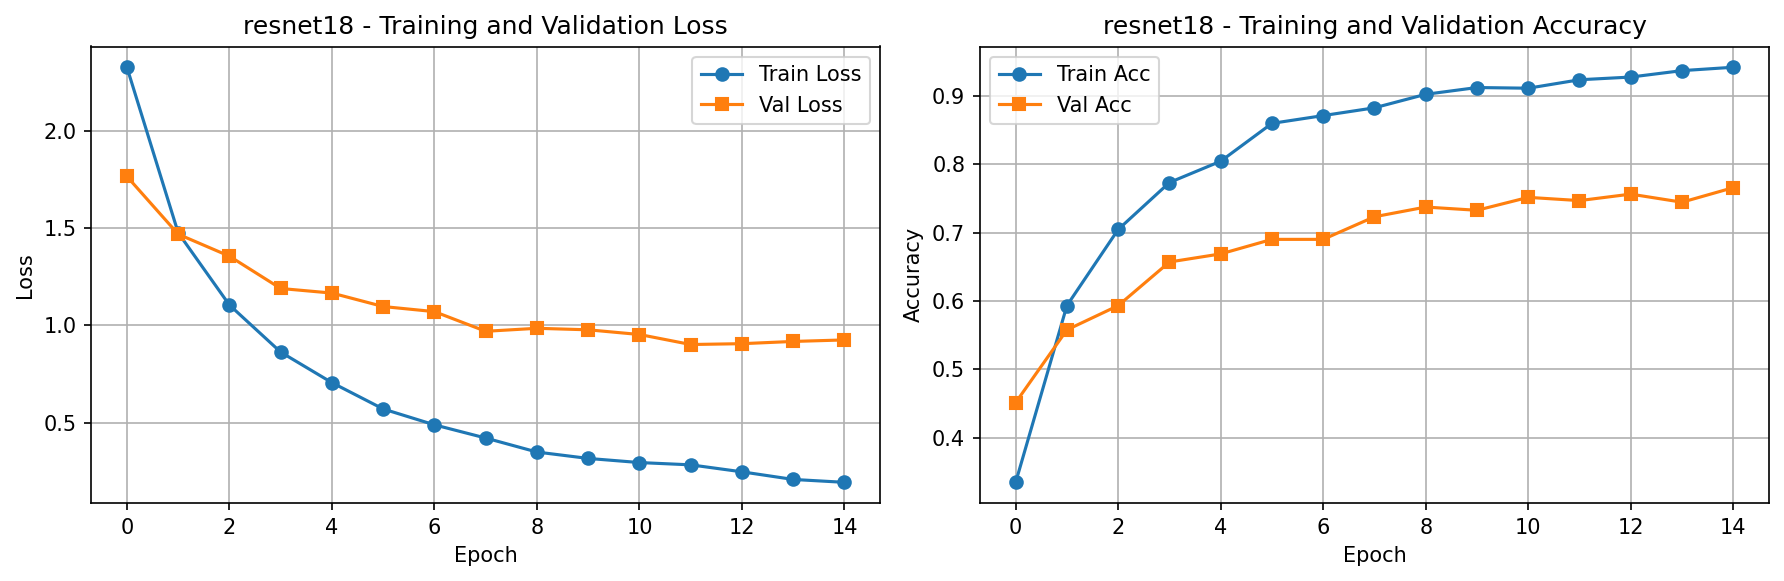



Images for RESNET50

confusion_matrix.png:


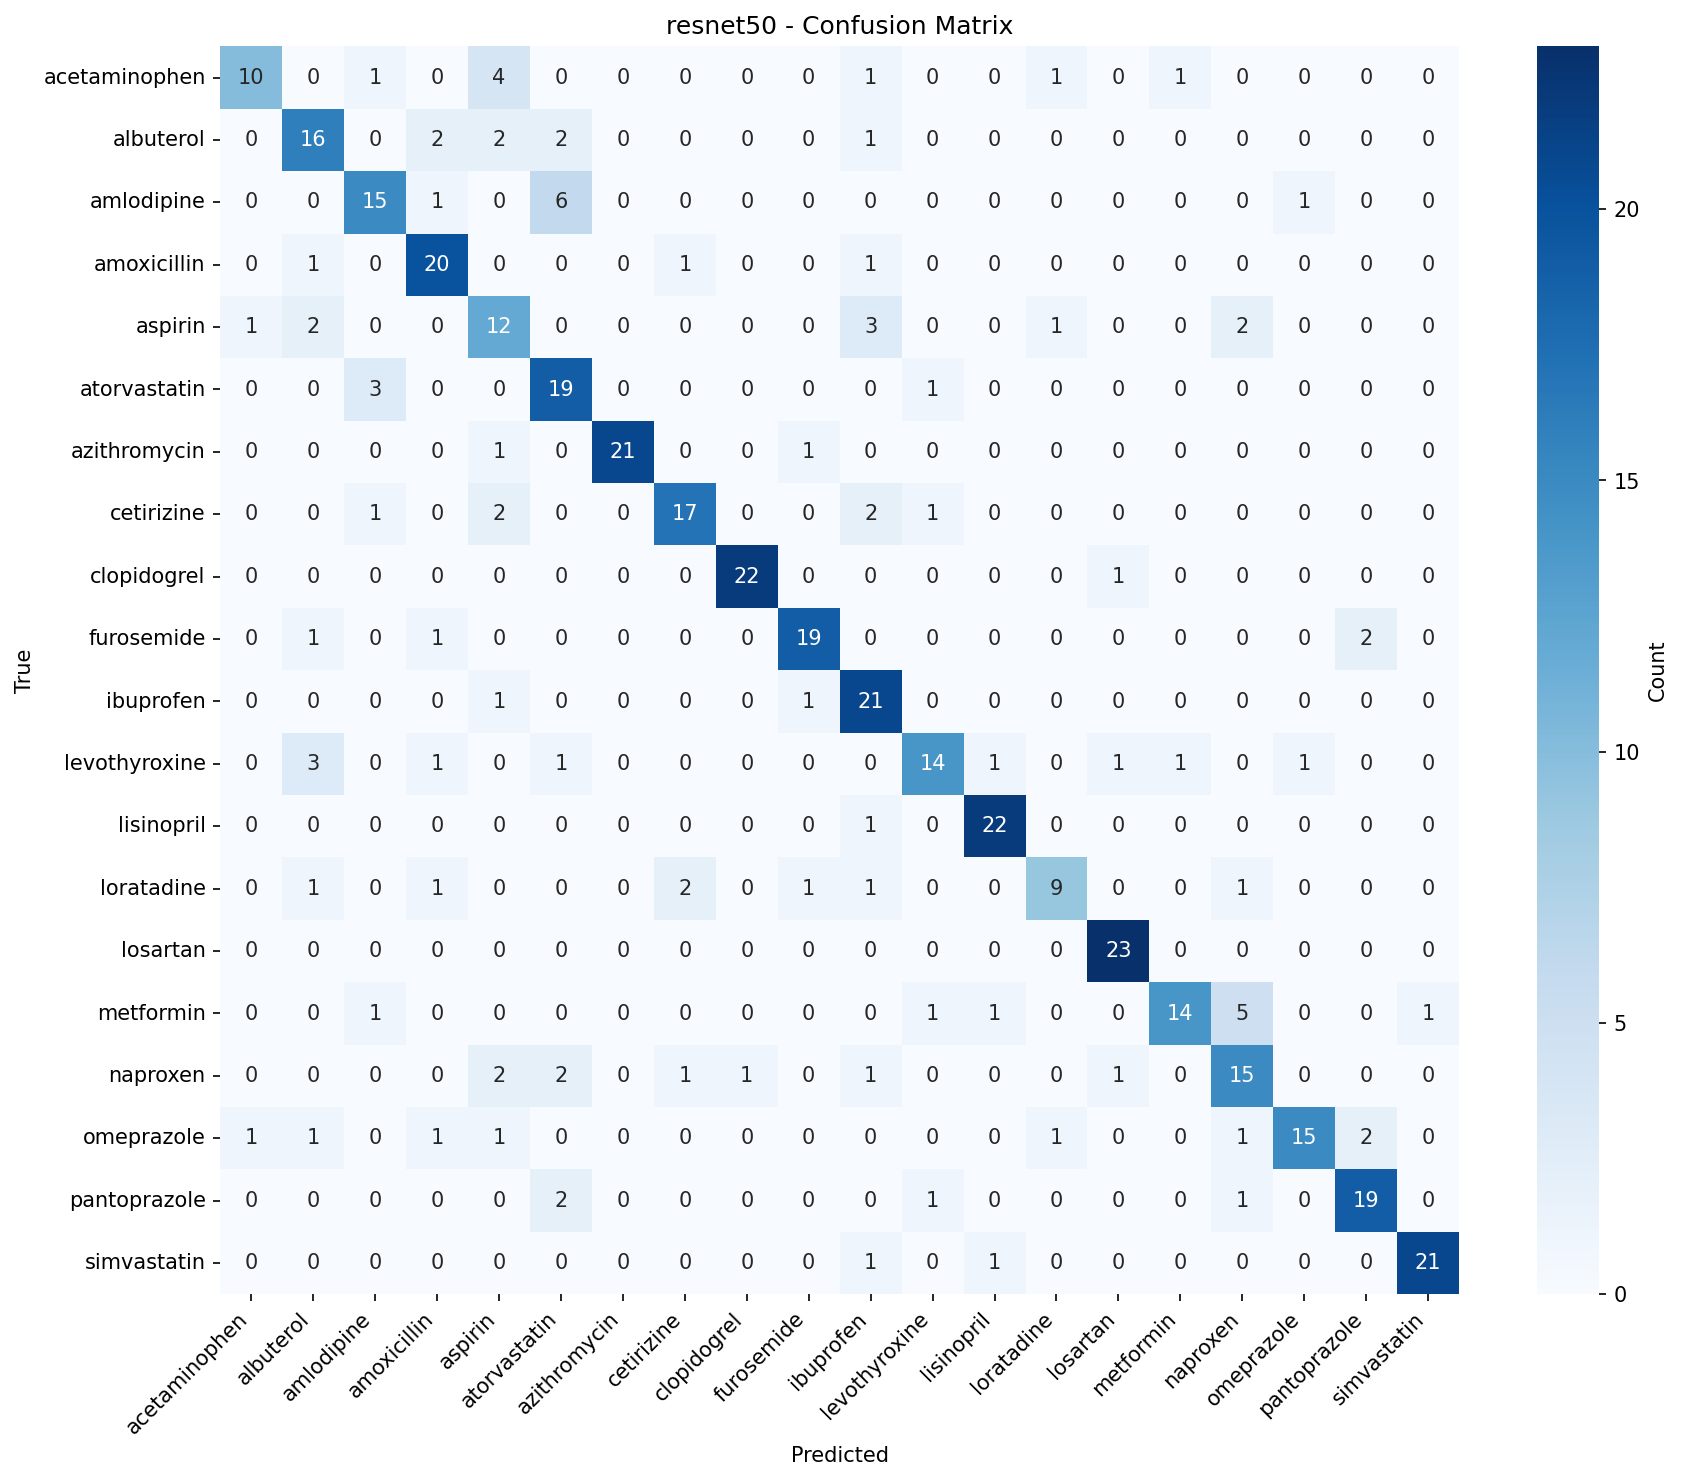


per_class_metrics.png:


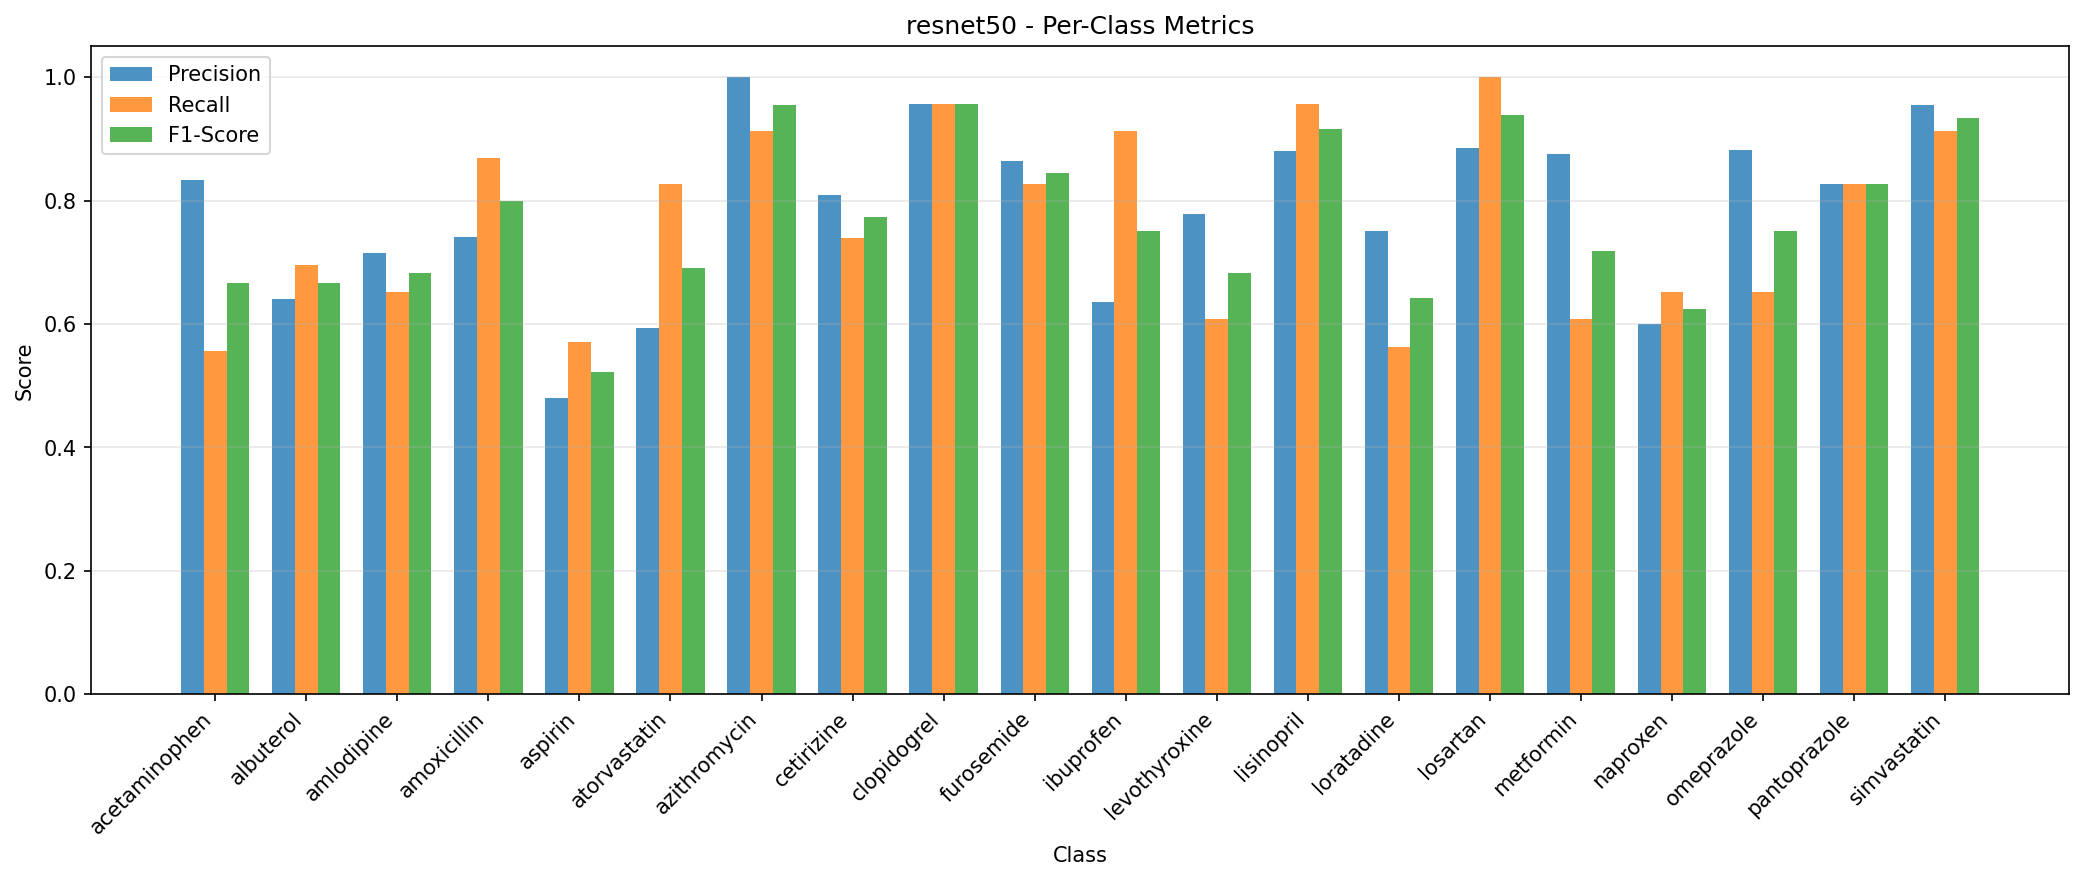


training_history.png:


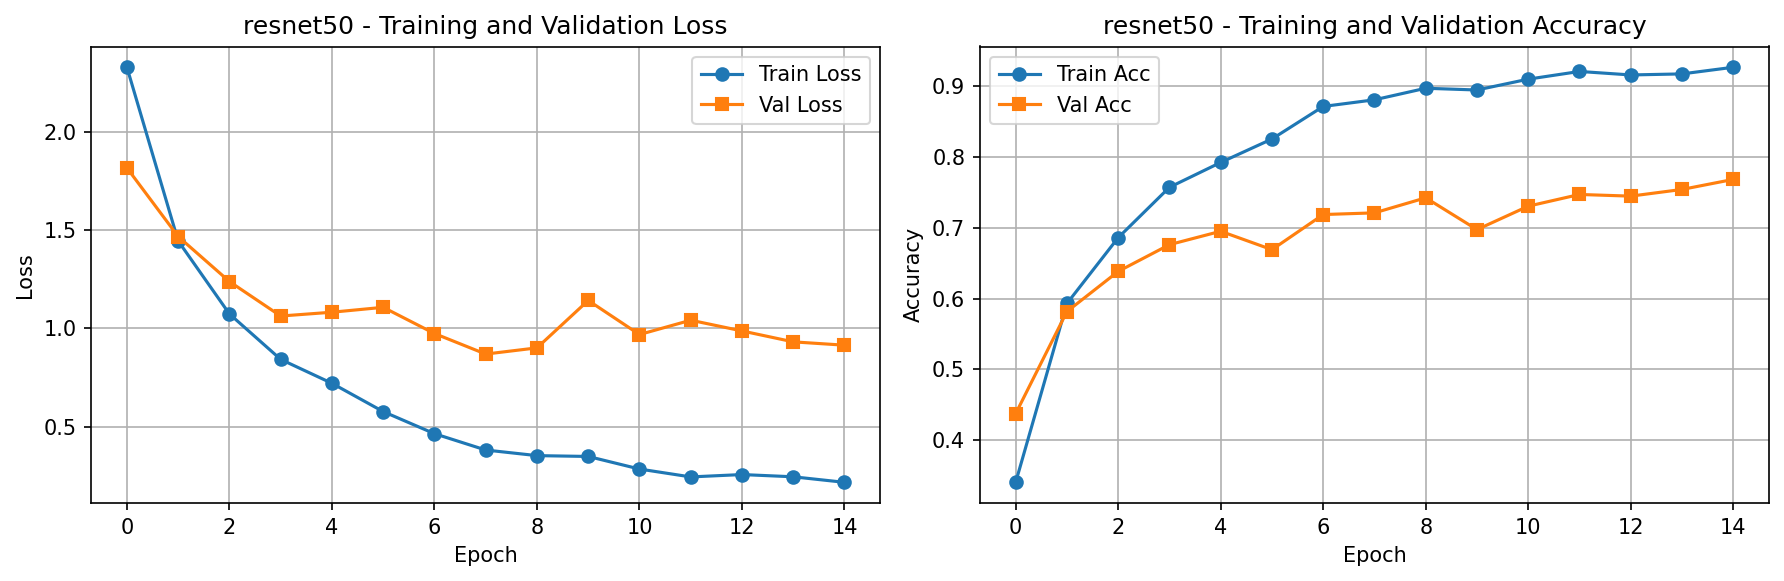



Images for VIT_B16

confusion_matrix.png:


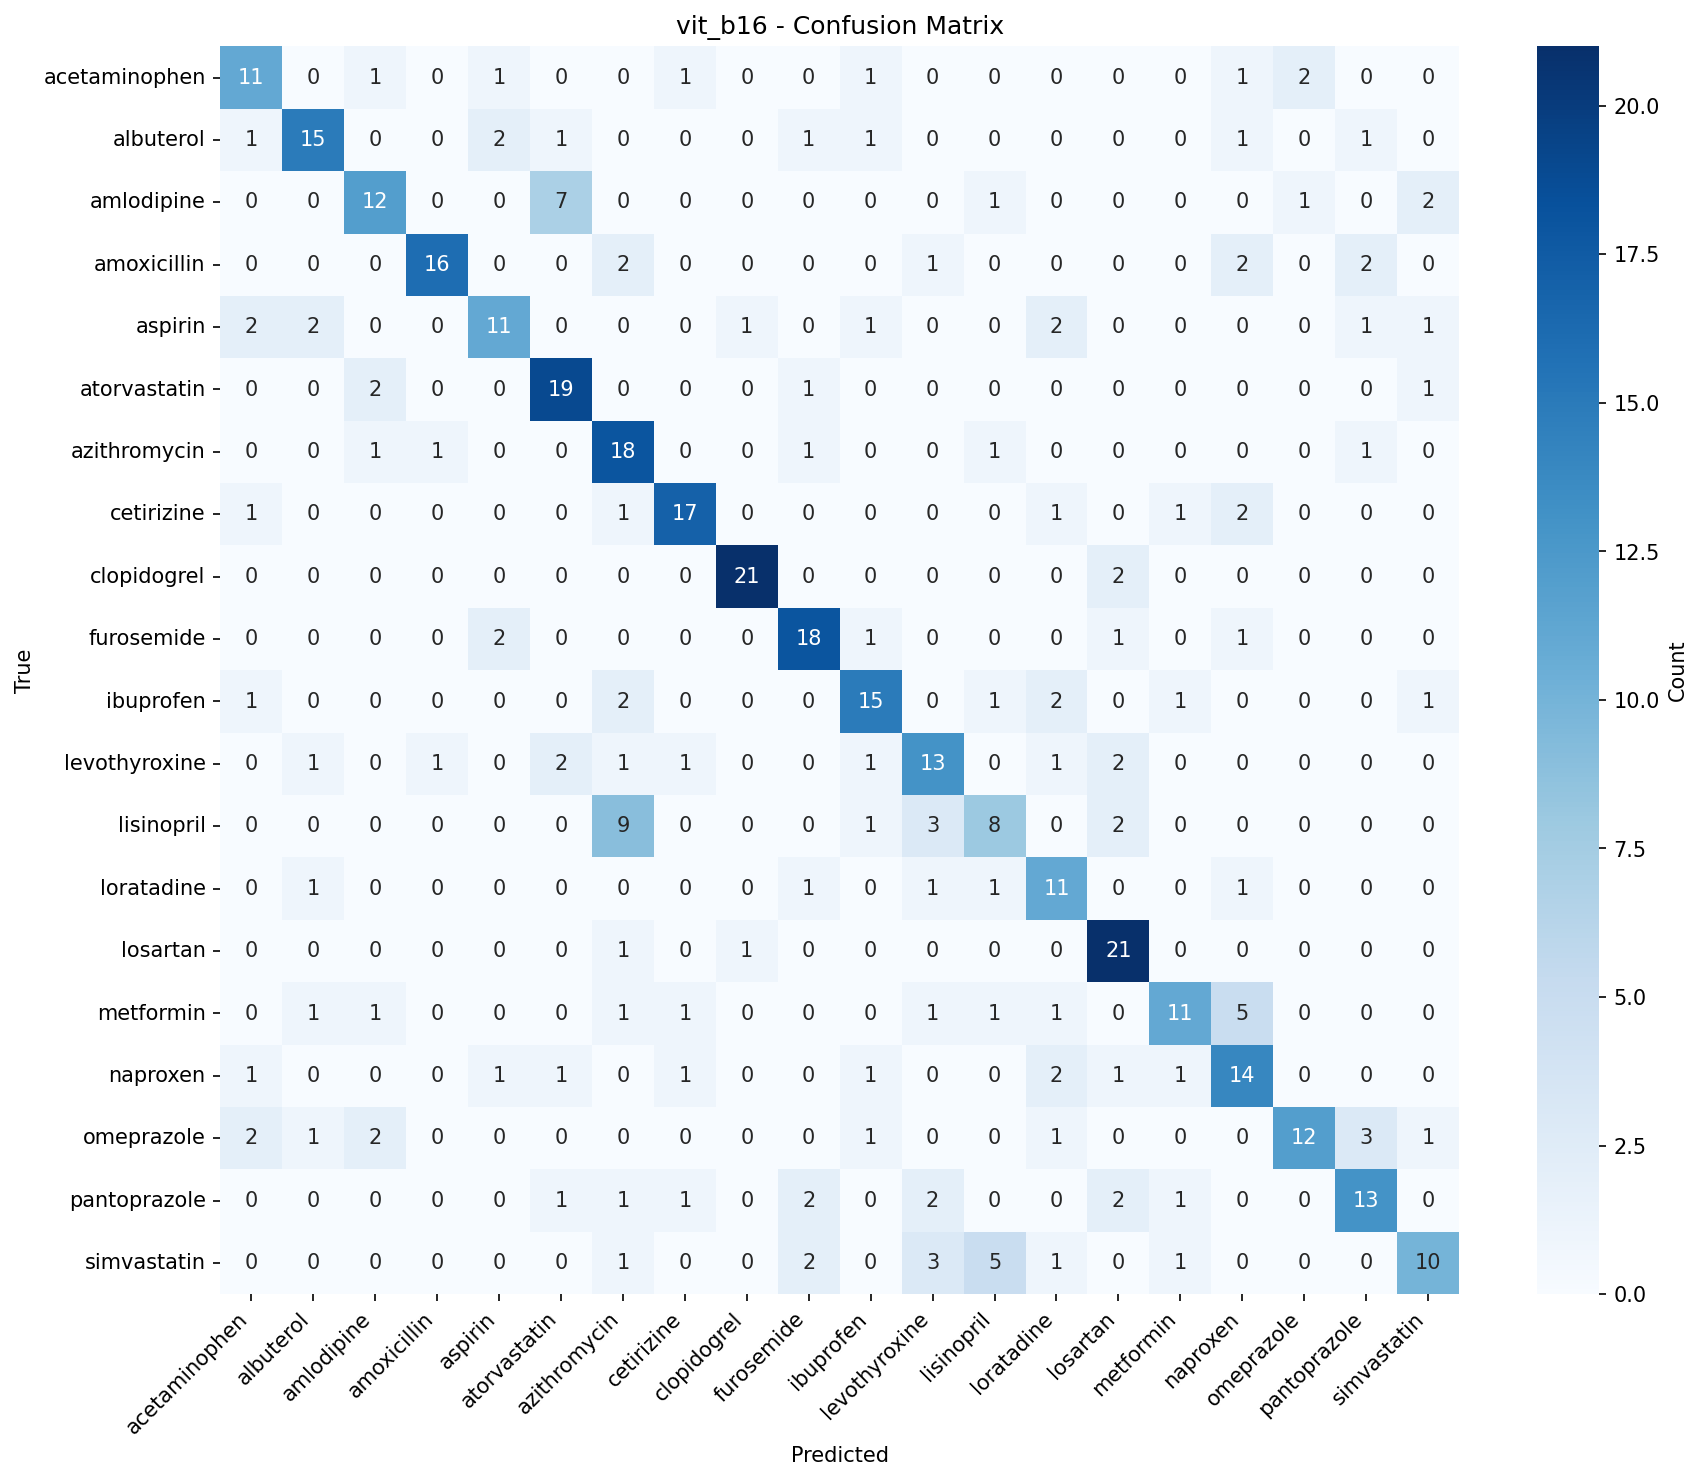


per_class_metrics.png:


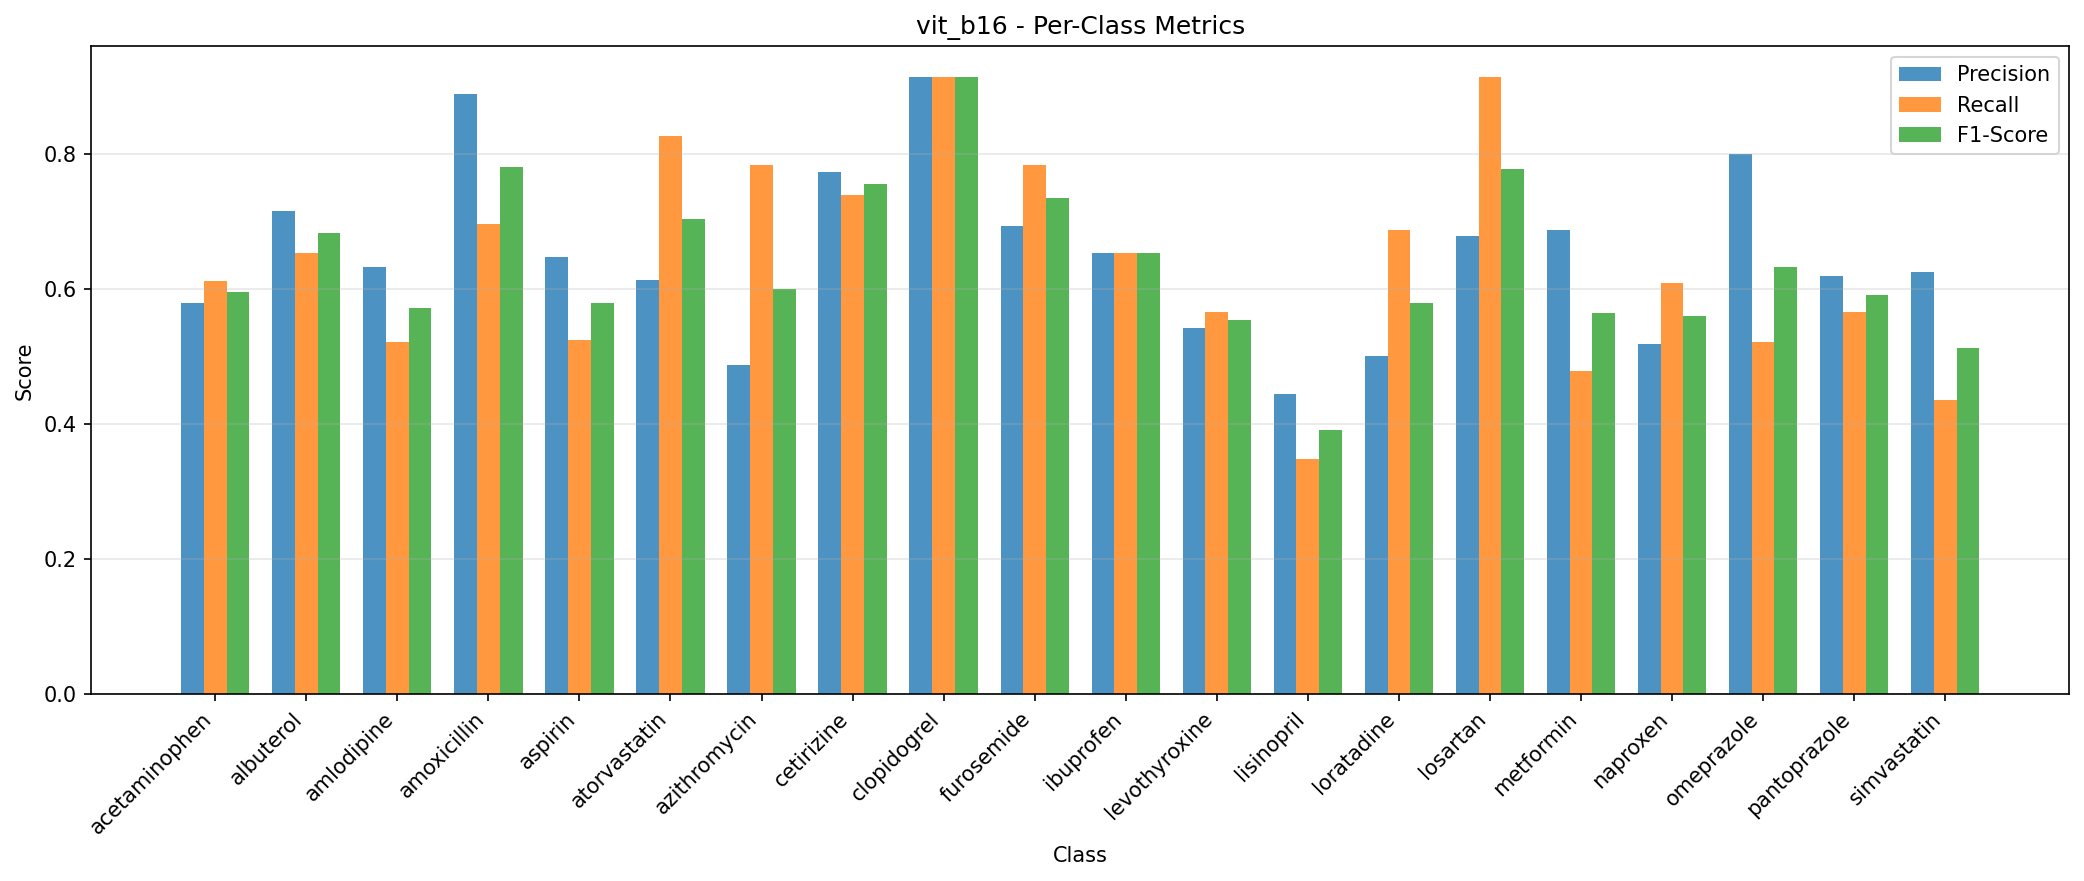


training_history.png:


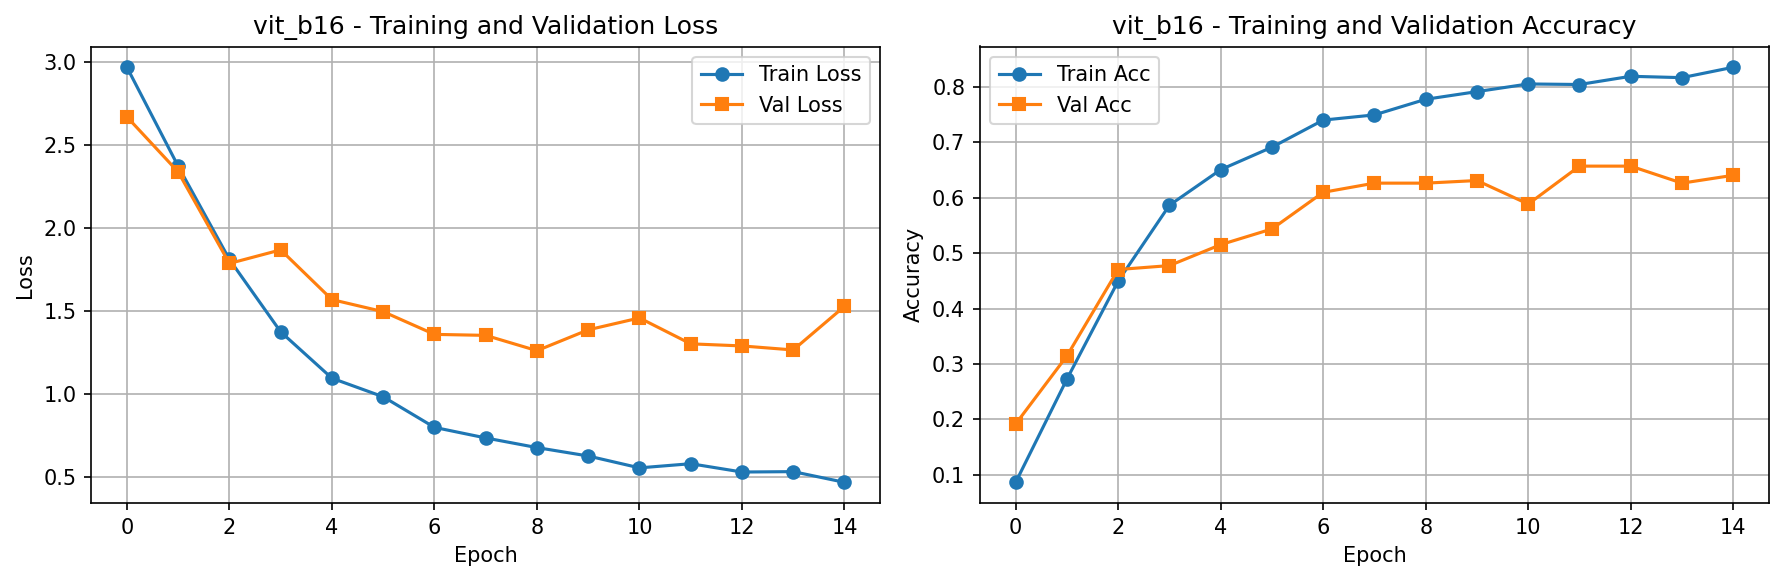



Images for VIT_S16

confusion_matrix.png:


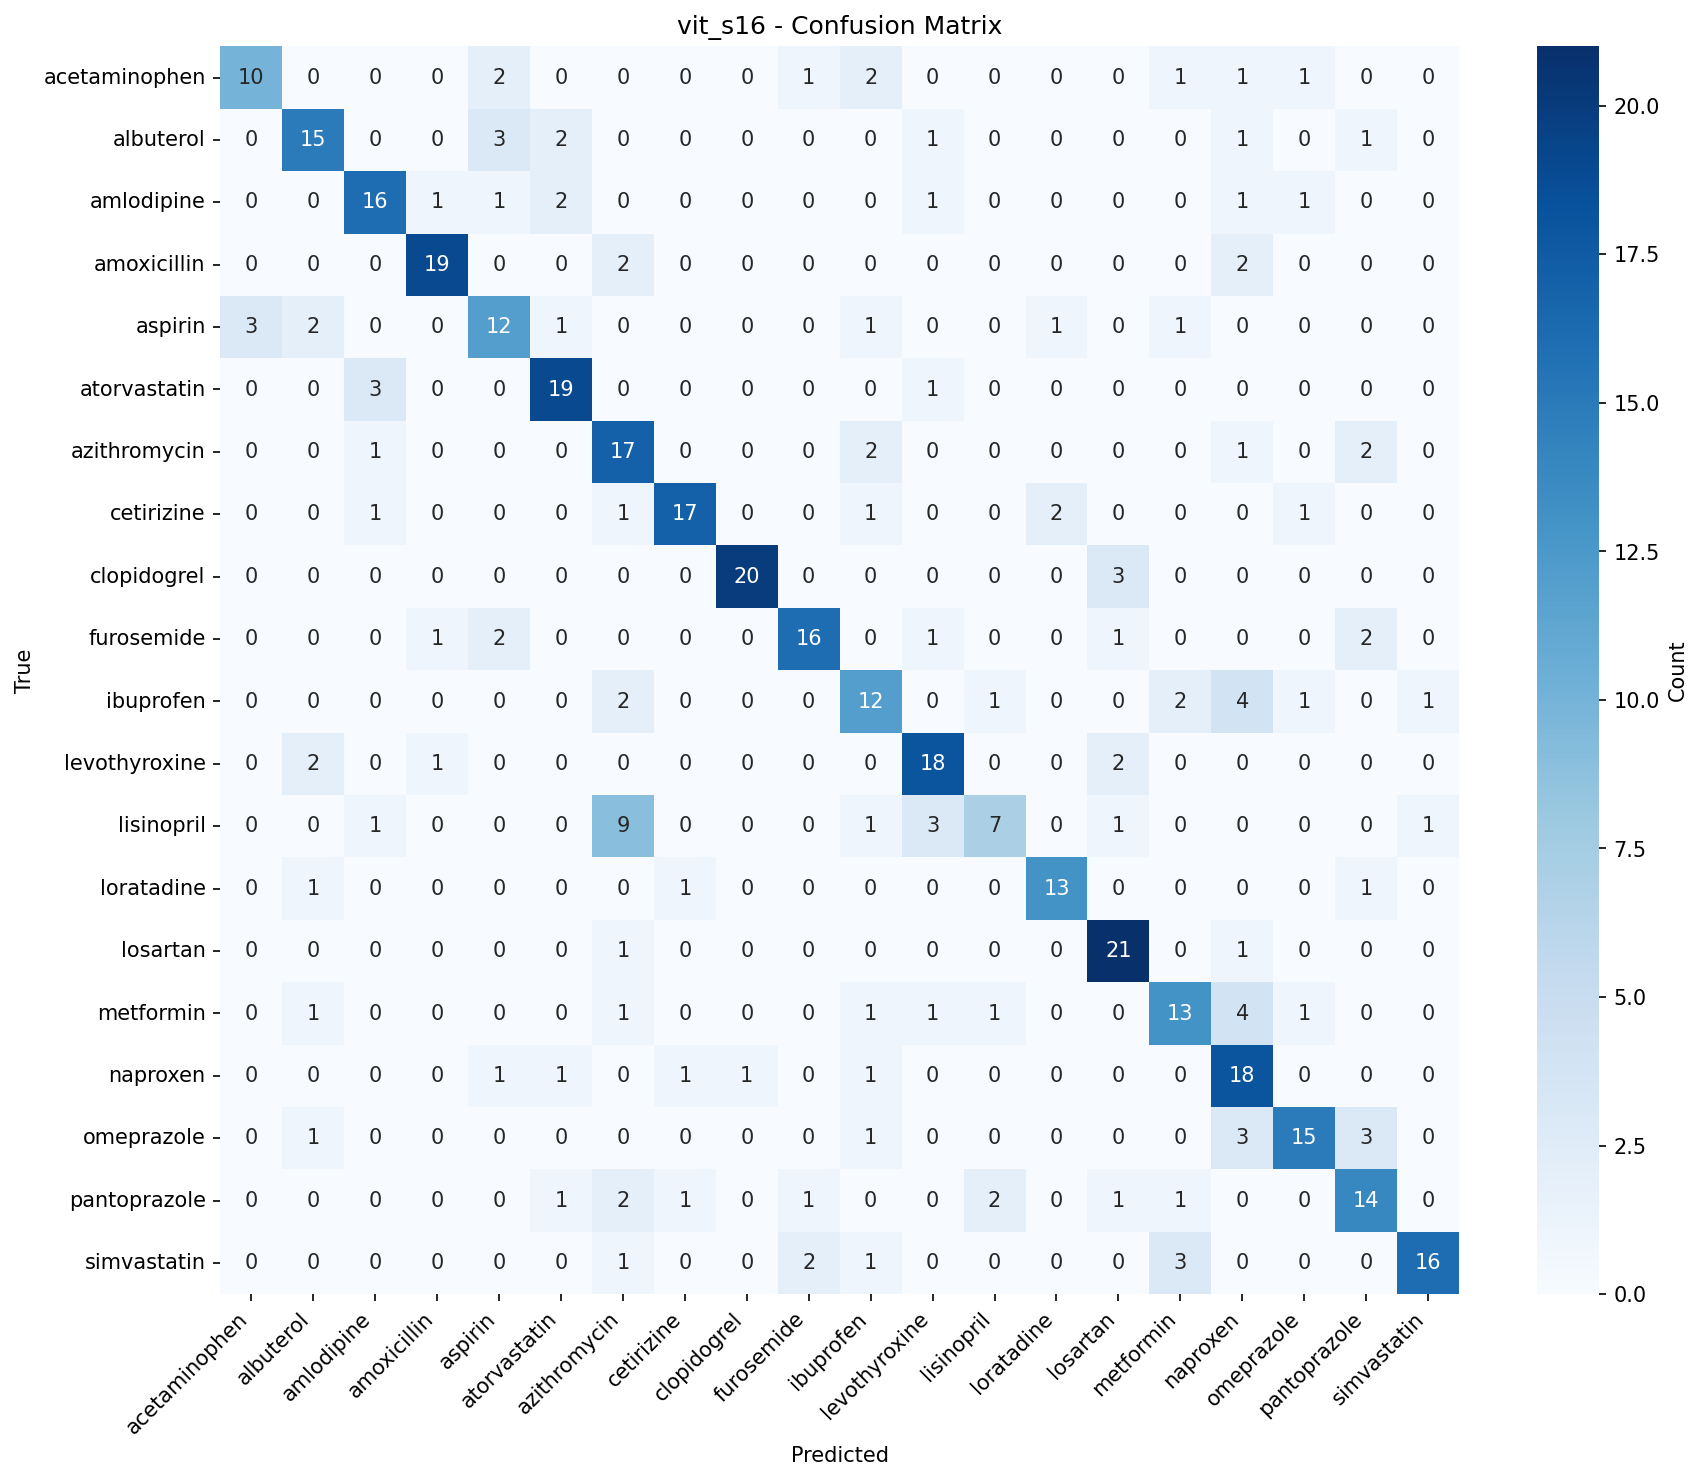


per_class_metrics.png:


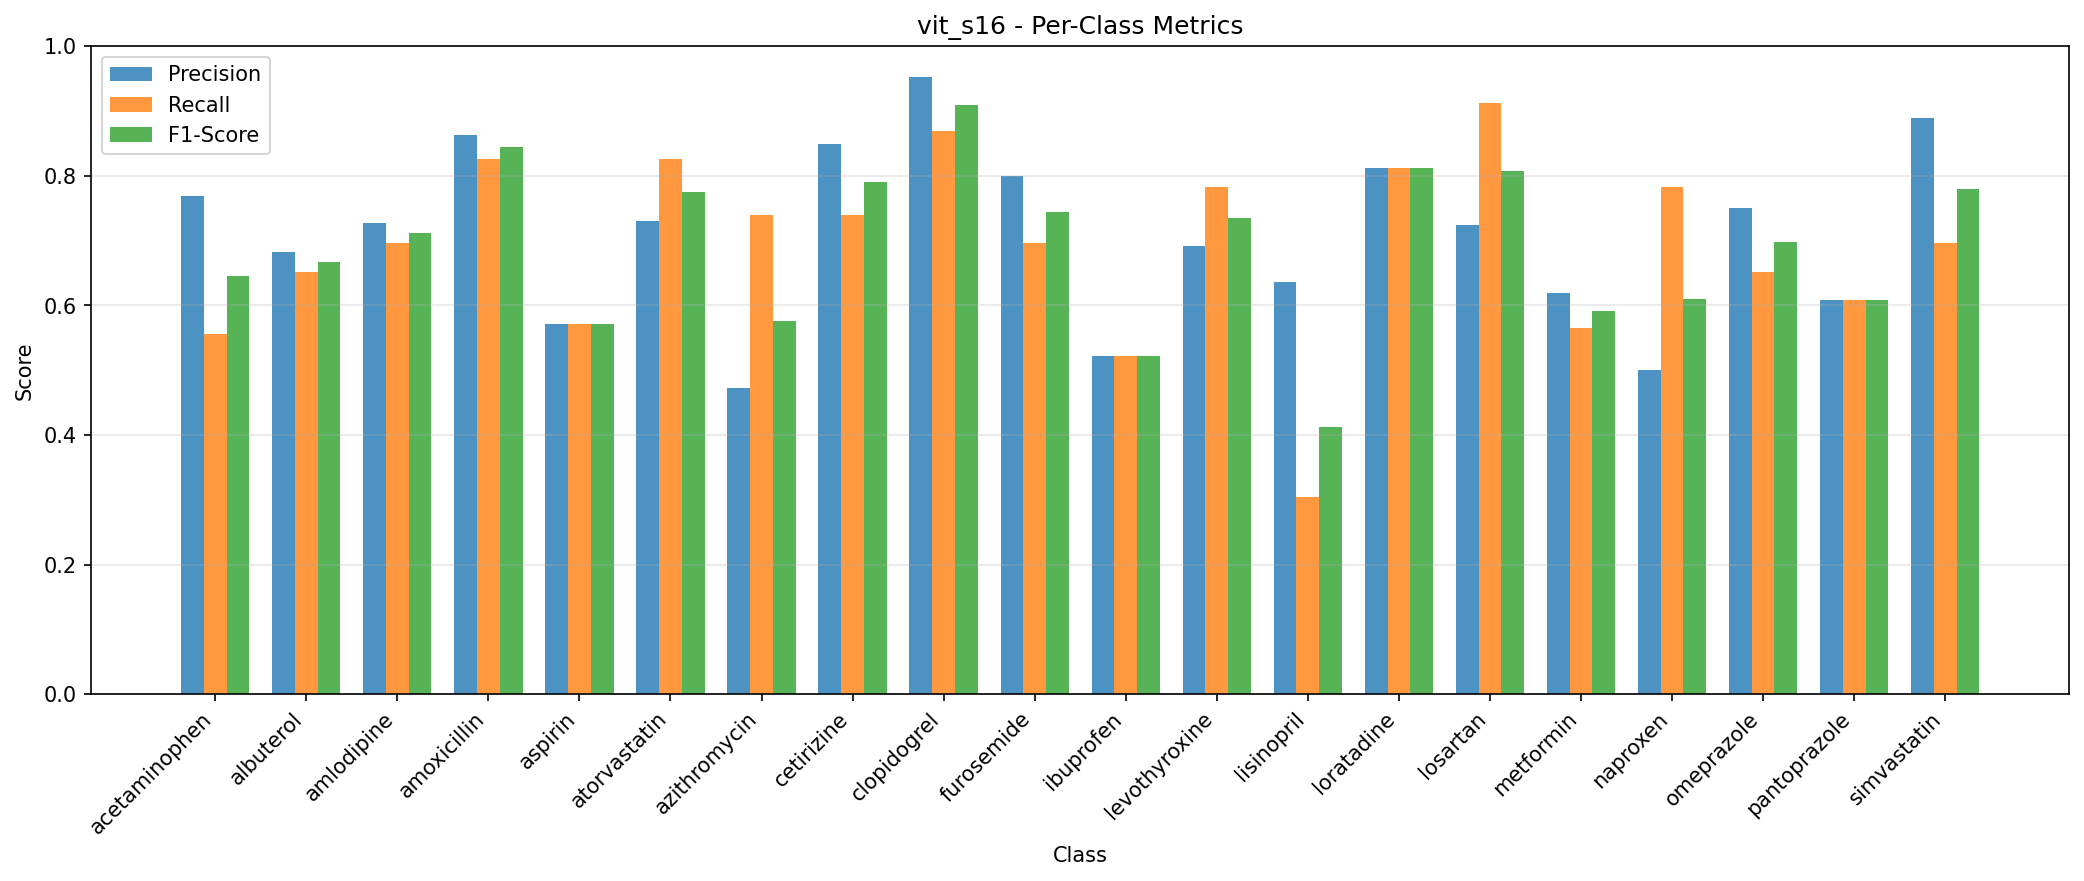


training_history.png:


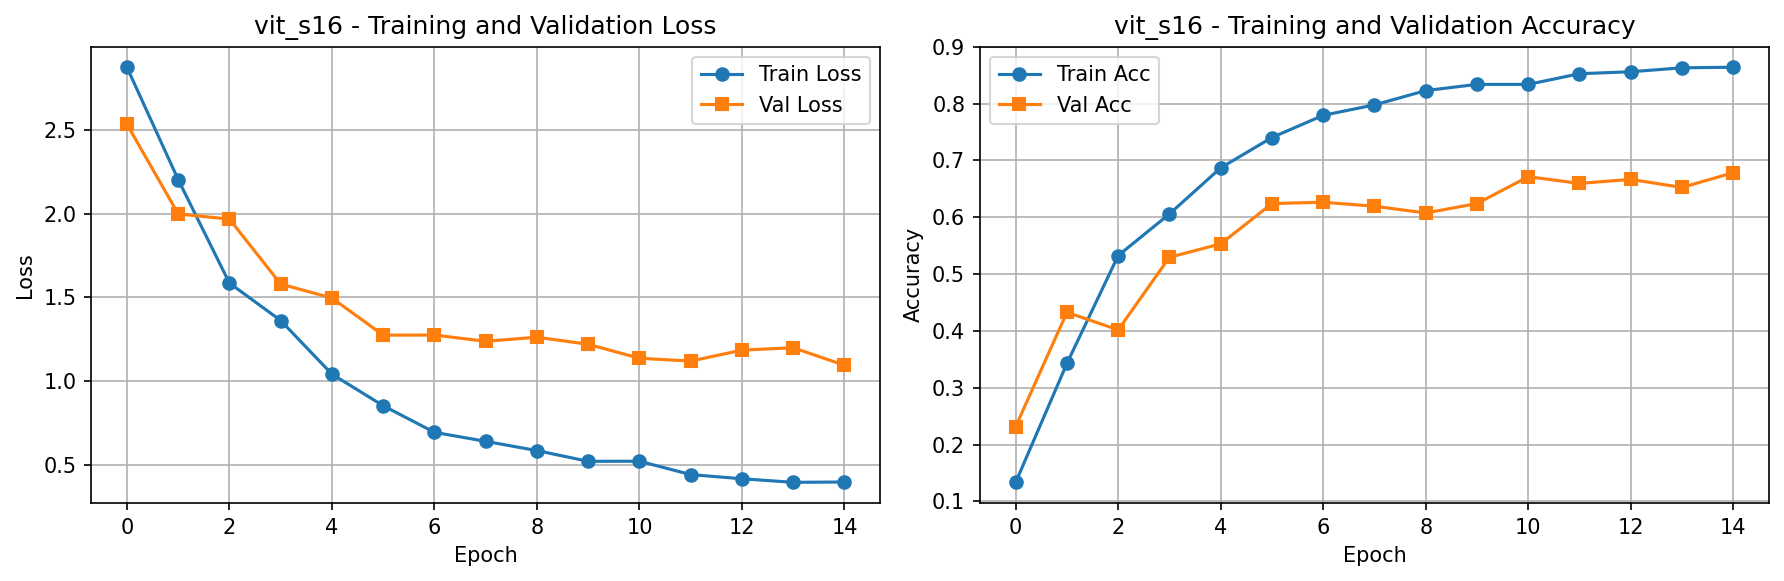



COMPARISON IMAGES

model_comparison.png:


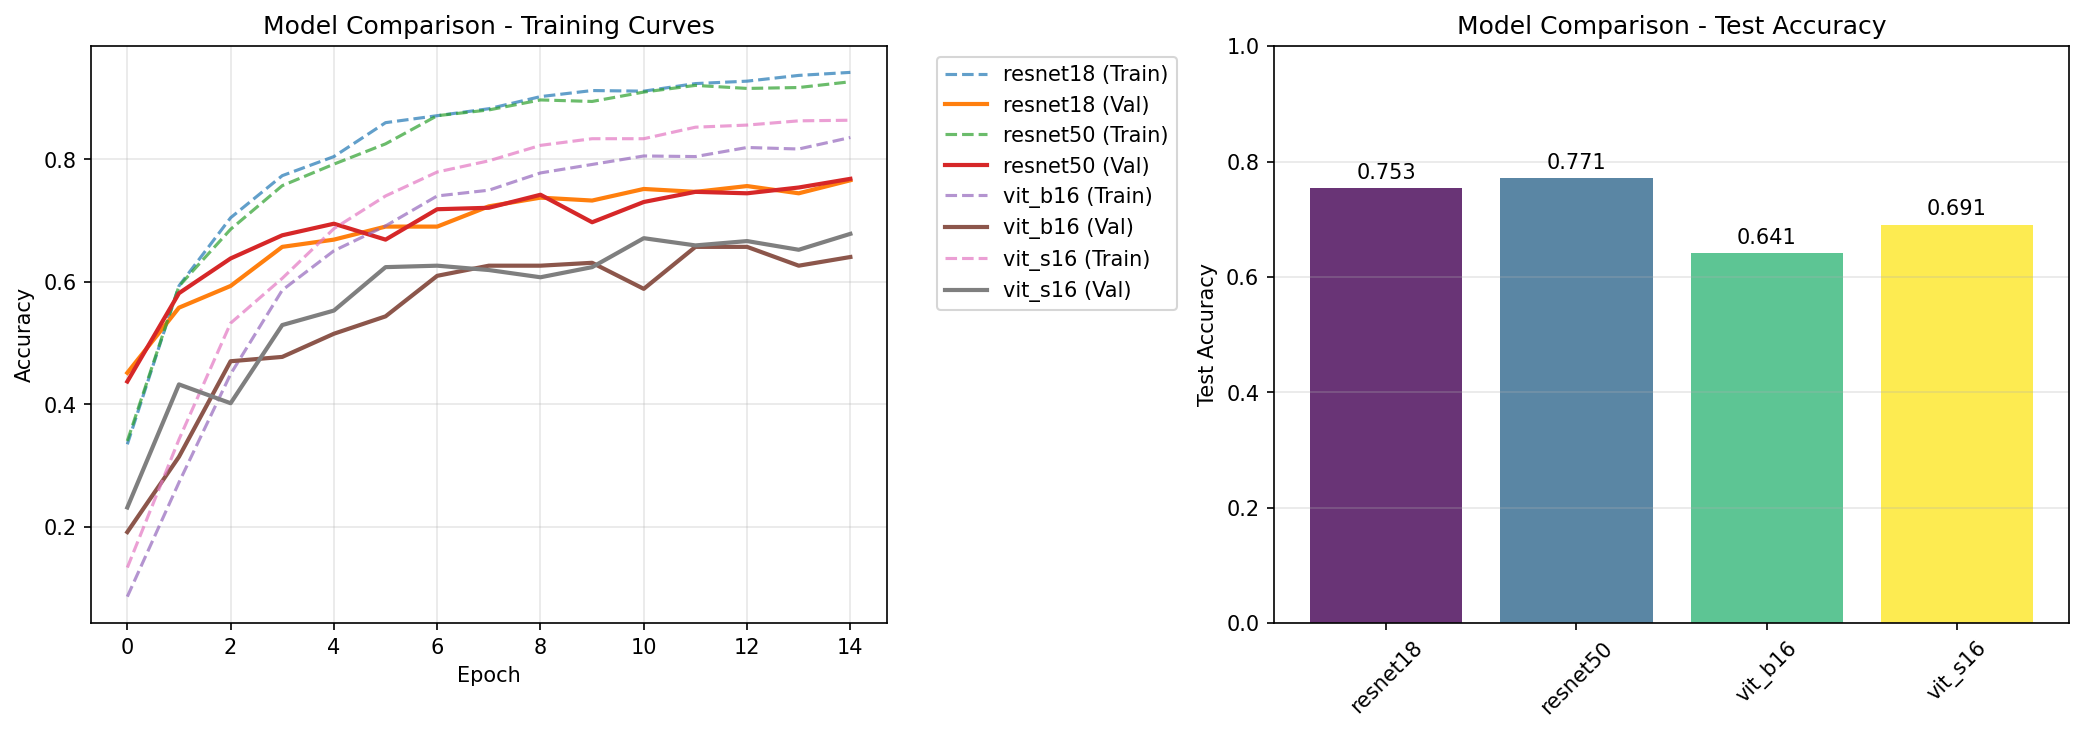

In [ ]:
from IPython.display import Image, display
from pathlib import Path

model_dirs = [d for d in os.listdir(results_base) 
              if os.path.isdir(os.path.join(results_base, d)) and d not in ['comparison']]

model_dirs = sorted(model_dirs)

for model_dir_name in model_dirs:
    model_dir = os.path.join(results_base, model_dir_name)
    
    image_files = sorted([f for f in os.listdir(model_dir) if f.endswith('.png')])
    
    if image_files:
        print(f"\n{'='*80}")
        print(f"Images for {model_dir_name.upper()}")
        print(f"{'='*80}\n")
        
        for img_file in image_files:
            img_path = os.path.join(model_dir, img_file)
            print(f"{img_file}:")
            display(Image(filename=img_path, width=800))
            print()

comparison_dir = os.path.join(results_base, "comparison")
if os.path.exists(comparison_dir):
    comparison_images = sorted([f for f in os.listdir(comparison_dir) if f.endswith('.png')])
    
    if comparison_images:
        print(f"\n{'='*80}")
        print("COMPARISON IMAGES")
        print(f"{'='*80}\n")
        
        for img_file in comparison_images:
            img_path = os.path.join(comparison_dir, img_file)
            print(f"{img_file}:")
            display(Image(filename=img_path, width=800))
            print()
